# Image classification from scratch

**Author:** Balaji Chippada <br>
**Linkedin:** https://www.linkedin.com/in/balaji-chippada-0317/ <br>
**Date created:** 2024/03/27<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

# Reference links -

1. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
2. https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
3. https://stackoverflow.com/questions/56450969/how-to-calculate-output-sizes-after-a-convolution-layer-in-a-configuration-file
4. https://www.tensorflow.org/api_docs/python/tf/keras/Model


# Dataset Link

1. Credits to :- https://www.kaggle.com/datasets/salader/dogs-vs-cats?select=train

# Setting up Data Directory

In [ ]:
# Create the .kaggle directory in your home directory
!mkdir -p ~/.kaggle

# Copy the kaggle.json file to the .kaggle directory
!cp kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:51<00:00, 24.6MB/s]
100% 1.06G/1.06G [00:51<00:00, 22.3MB/s]


In [ ]:
!unzip /content/dogs-vs-cats.zip -d /content/

# Installing the required libraries

In [ ]:
!pip3 install tensorflow numpy matplotlib keras

# Importing Packages

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Reading the data

In [ ]:
list_cats = ['/content/dogs_vs_cats/train/cats/cat.0.jpg', '/content/dogs_vs_cats/train/cats/cat.1.jpg']

In [ ]:
os.listdir('/content/dogs_vs_cats/train/dogs')

In [ ]:
random.sample(os.listdir('/content/dogs_vs_cats/train/dogs'), 5)

['dog.6684.jpg',
 'dog.9466.jpg',
 'dog.2148.jpg',
 'dog.6891.jpg',
 'dog.1623.jpg']

In [ ]:
/content/dogs_vs_cats/train/cats/cat.0.jpg

In [ ]:
os.path.join("/content/dogs_vs_cats/train/cats/", 'cat.0.jpg')

'/content/dogs_vs_cats/train/cats/cat.0.jpg'

In [5]:
def plot_images_from_directory(directory_path, class_animal, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_animal}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

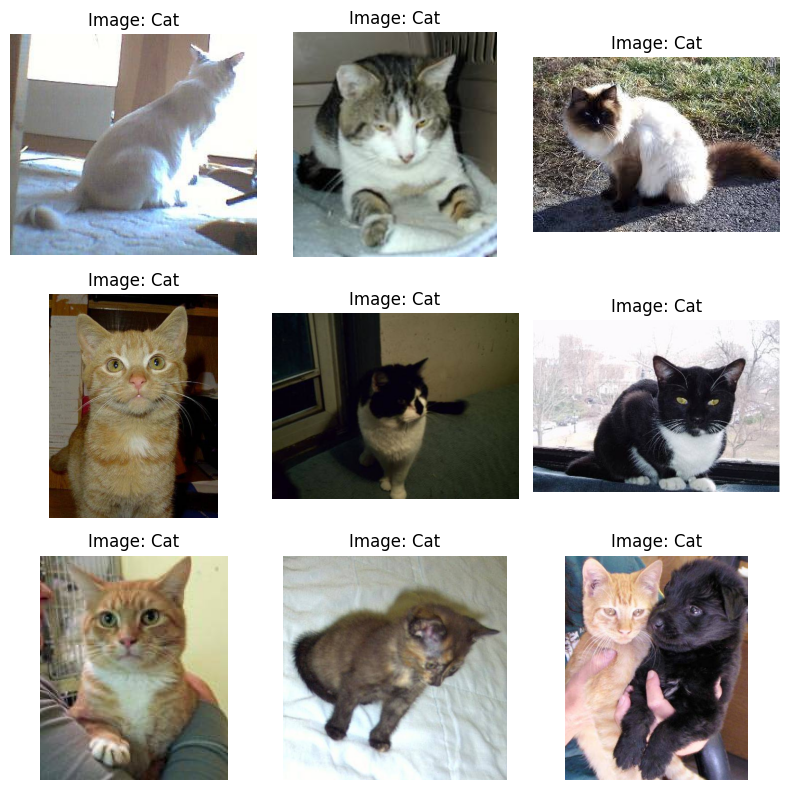

In [6]:
# Placeholder for the directory path
cat_directory_path = '/content/dogs_vs_cats/train/cats'  # Replace with your directory path
plot_images_from_directory(cat_directory_path, class_animal = 'Cat')

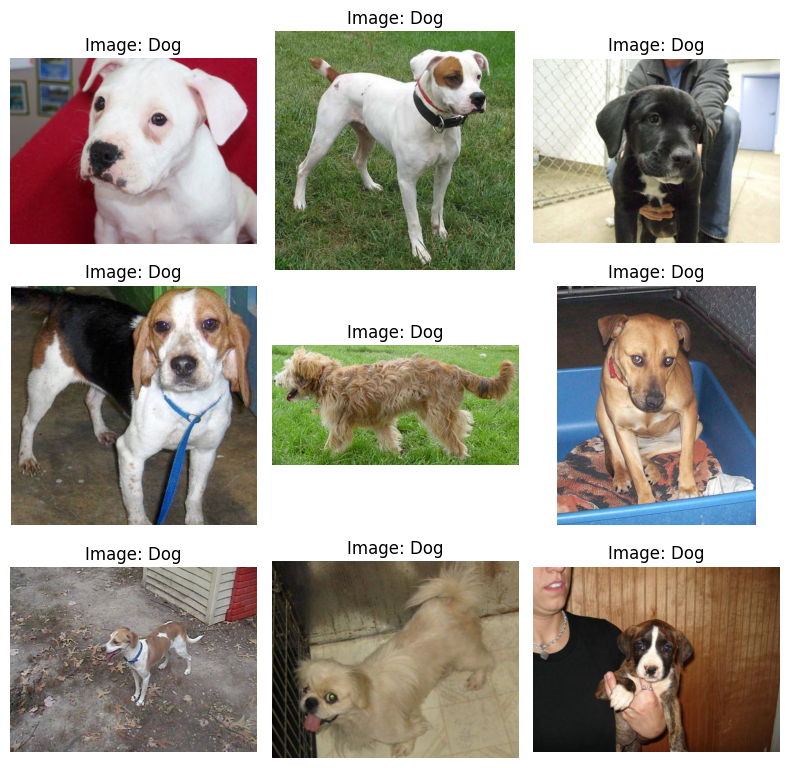

In [7]:
# Placeholder for the directory path
dog_directory_path = '/content/dogs_vs_cats/train/dogs'  # Replace with your directory path
plot_images_from_directory(dog_directory_path, class_animal = 'Dog')

# Data Analysis

In [8]:
cat_images = os.listdir(cat_directory_path)
dog_images = os.listdir(dog_directory_path)

classes_animals = ['Cats', 'Dogs']
count = [len(cat_images), len(dog_images)]

print(count)

[10000, 10000]


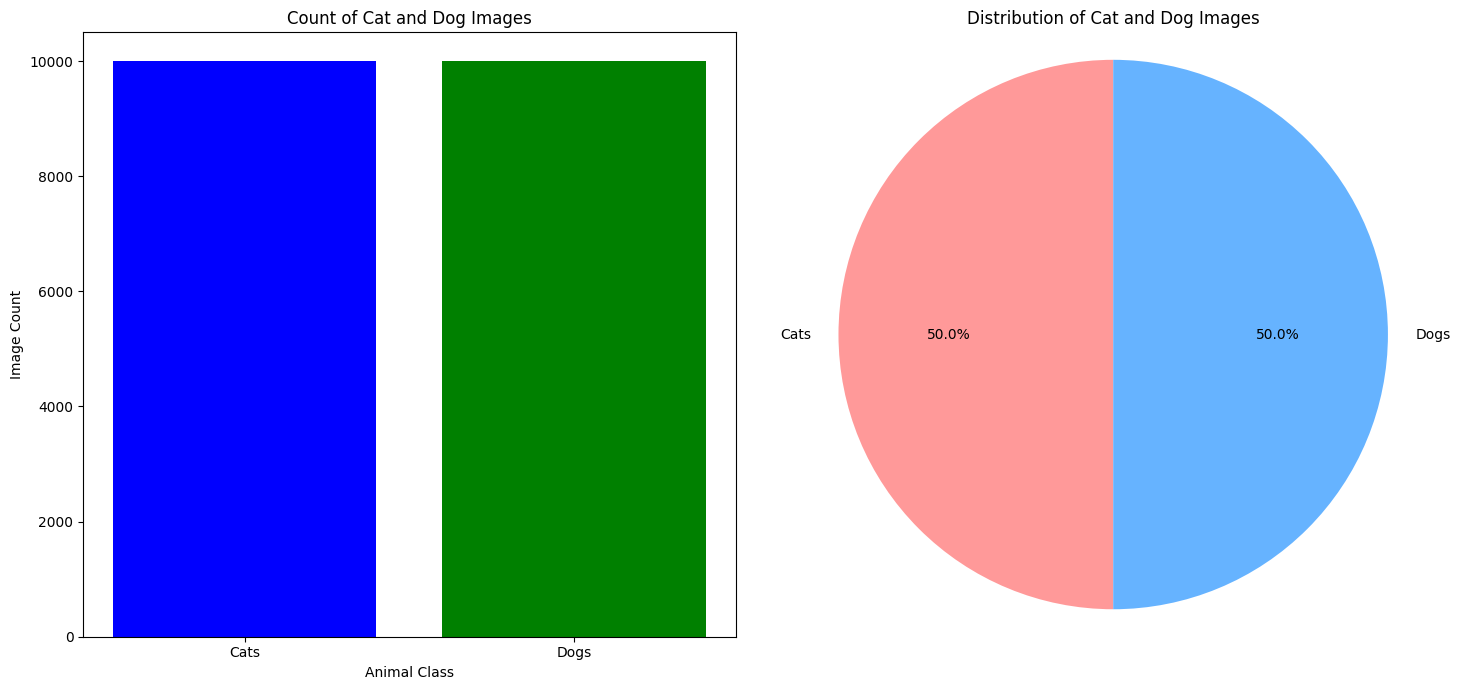

In [9]:
# Creating both a bar chart and a pie chart side by side in a single figure

# Setting up a figure and axes for two subplots: one for the bar chart, one for the pie chart
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Bar chart on the first subplot
ax[0].bar(classes_animals, count, color=['blue', 'green'])
ax[0].set_xlabel('Animal Class')
ax[0].set_ylabel('Image Count')
ax[0].set_title('Count of Cat and Dog Images')

# Pie chart on the second subplot
colors = ['#ff9999','#66b3ff']
ax[1].pie(count, labels=classes_animals, colors=colors, autopct='%1.1f%%', startangle=90)
ax[1].set_title('Distribution of Cat and Dog Images')
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust the layout so that both subplots fit nicely
plt.tight_layout()
plt.show()


# Removing Corrupted Images

In [10]:
import os
import cv2
import imghdr

# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/dogs_vs_cats'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

# Loading Shapes and Channels

In [11]:
import numpy as np
from PIL import Image

def image_to_array(image_path):
    """
    Read an image and convert it to a numpy array.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    np.array: The image as a numpy array.
    """
    try:
        with Image.open(image_path) as img:
            image_array = np.array(img)
            return image_array
    except IOError:
        print(f"Could not read the image file at {image_path}.")
        return None

array([[[238, 224, 211],
        [169, 153, 137],
        [139, 116,  98],
        ...,
        [133, 102,  82],
        [128,  97,  77],
        [127,  96,  76]],

       [[250, 234, 219],
        [173, 154, 137],
        [133, 108,  86],
        ...,
        [115,  84,  64],
        [111,  80,  59],
        [110,  79,  59]],

       [[248, 230, 210],
        [170, 148, 127],
        [129, 101,  77],
        ...,
        [ 85,  54,  33],
        [ 83,  53,  29],
        [ 84,  53,  32]],

       ...,

       [[255, 255, 244],
        [254, 255, 241],
        [252, 250, 237],
        ...,
        [239, 240, 224],
        [238, 239, 223],
        [238, 239, 223]],

       [[255, 255, 244],
        [255, 255, 242],
        [252, 253, 239],
        ...,
        [245, 246, 232],
        [244, 245, 231],
        [244, 245, 231]],

       [[255, 255, 244],
        [255, 255, 243],
        [254, 255, 241],
        ...,
        [250, 251, 237],
        [248, 249, 235],
        [249, 250, 236]]], dtype=uint8)
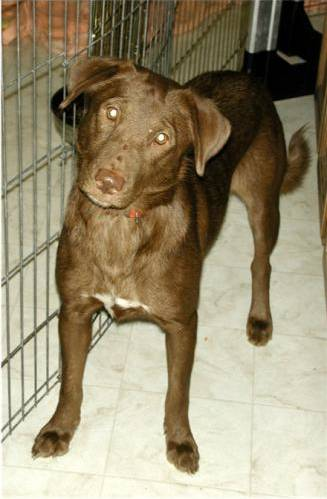

In [12]:
image_to_array('/content/dogs_vs_cats/train/dogs/dog.1.jpg')

## Using CV2

In [13]:
image = '/content/dogs_vs_cats/train/dogs/dog.1.jpg'

import cv2

img = cv2.imread(image)

# If the image is loaded successfully, print its pixel values
if img is not None:
    print(img)
    print(img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

[[[211 224 238]
  [137 153 169]
  [ 98 116 139]
  ...
  [ 82 102 133]
  [ 77  97 128]
  [ 76  96 127]]

 [[219 234 250]
  [137 154 173]
  [ 86 108 133]
  ...
  [ 64  84 115]
  [ 59  80 111]
  [ 59  79 110]]

 [[210 230 248]
  [127 148 170]
  [ 77 101 129]
  ...
  [ 33  54  85]
  [ 29  53  83]
  [ 32  53  84]]

 ...

 [[244 255 255]
  [241 255 254]
  [237 250 252]
  ...
  [224 240 239]
  [223 239 238]
  [223 239 238]]

 [[244 255 255]
  [242 255 255]
  [239 253 252]
  ...
  [232 246 245]
  [231 245 244]
  [231 245 244]]

 [[244 255 255]
  [243 255 255]
  [241 255 254]
  ...
  [237 251 250]
  [235 249 248]
  [236 250 249]]]
(499, 327, 3)


## Using python

In [14]:
# Import necessary libraries
import numpy as np
from PIL import Image


# Load the image with PIL and convert to a NumPy array
img_pil = Image.open(image)
img_array = np.array(img_pil)

# Print the NumPy array of the image
print(img_array)

# Print the NumPy array of the image
print(img_array.shape)

[[[238 224 211]
  [169 153 137]
  [139 116  98]
  ...
  [133 102  82]
  [128  97  77]
  [127  96  76]]

 [[250 234 219]
  [173 154 137]
  [133 108  86]
  ...
  [115  84  64]
  [111  80  59]
  [110  79  59]]

 [[248 230 210]
  [170 148 127]
  [129 101  77]
  ...
  [ 85  54  33]
  [ 83  53  29]
  [ 84  53  32]]

 ...

 [[255 255 244]
  [254 255 241]
  [252 250 237]
  ...
  [239 240 224]
  [238 239 223]
  [238 239 223]]

 [[255 255 244]
  [255 255 242]
  [252 253 239]
  ...
  [245 246 232]
  [244 245 231]
  [244 245 231]]

 [[255 255 244]
  [255 255 243]
  [254 255 241]
  ...
  [250 251 237]
  [248 249 235]
  [249 250 236]]]
(499, 327, 3)


In [15]:
for i,j,k in os.walk('/content/dogs_vs_cats'):
    print(i,j,k)

/content/dogs_vs_cats ['test', 'train'] []
/content/dogs_vs_cats/test ['cats', 'dogs'] []
/content/dogs_vs_cats/test/cats [] ['cat.5596.jpg', 'cat.960.jpg', 'cat.11886.jpg', 'cat.5770.jpg', 'cat.5614.jpg', 'cat.1566.jpg', 'cat.3276.jpg', 'cat.8497.jpg', 'cat.7284.jpg', 'cat.3579.jpg', 'cat.234.jpg', 'cat.8538.jpg', 'cat.690.jpg', 'cat.10540.jpg', 'cat.4285.jpg', 'cat.9127.jpg', 'cat.8942.jpg', 'cat.9115.jpg', 'cat.6149.jpg', 'cat.4237.jpg', 'cat.961.jpg', 'cat.2915.jpg', 'cat.12117.jpg', 'cat.11995.jpg', 'cat.3278.jpg', 'cat.808.jpg', 'cat.3781.jpg', 'cat.4322.jpg', 'cat.3037.jpg', 'cat.6815.jpg', 'cat.4784.jpg', 'cat.8350.jpg', 'cat.7531.jpg', 'cat.9057.jpg', 'cat.8533.jpg', 'cat.3800.jpg', 'cat.10560.jpg', 'cat.135.jpg', 'cat.7691.jpg', 'cat.5969.jpg', 'cat.5674.jpg', 'cat.2100.jpg', 'cat.1557.jpg', 'cat.3332.jpg', 'cat.42.jpg', 'cat.6583.jpg', 'cat.12069.jpg', 'cat.10939.jpg', 'cat.9166.jpg', 'cat.9347.jpg', 'cat.4783.jpg', 'cat.9083.jpg', 'cat.7477.jpg', 'cat.12491.jpg', 'cat.10853

In [ ]:
!pip3 install opencv-python

# Building Model

In [16]:
# Set path to the dataset
base_dir = '/content/dogs_vs_cats/train'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [17]:
 # Using 20% of data for validation
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),  # Resizing images to 150x150
    batch_size=20,
    class_mode='binary',  # Since we use binary_crossentropy loss, we need binary labels
    subset='training')  # Set as training data

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    subset='validation')  # Set as validation data

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


# Getting Class Labels

In [18]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

Training class labels: {'cats': 0, 'dogs': 1}
Validation class labels: {'cats': 0, 'dogs': 1}


# visualising the Batch Images

In [19]:
images, labels = next(train_generator)
images, labels

(array([[[[0.20392159, 0.15294118, 0.07843138],
          [0.20000002, 0.14901961, 0.07450981],
          [0.20784315, 0.15686275, 0.08235294],
          ...,
          [0.0509804 , 0.02352941, 0.0509804 ],
          [0.        , 0.01568628, 0.0509804 ],
          [0.03137255, 0.01568628, 0.01176471]],
 
         [[0.19607845, 0.14509805, 0.07058824],
          [0.19607845, 0.14509805, 0.07058824],
          [0.21568629, 0.16470589, 0.09019608],
          ...,
          [0.10588236, 0.07058824, 0.03529412],
          [0.02745098, 0.03529412, 0.        ],
          [0.09411766, 0.07843138, 0.07450981]],
 
         [[0.19607845, 0.14509805, 0.07058824],
          [0.21568629, 0.16470589, 0.09019608],
          [0.21960786, 0.16862746, 0.09411766],
          ...,
          [0.30588236, 0.2901961 , 0.28627452],
          [0.13725491, 0.15686275, 0.14117648],
          [0.07450981, 0.0509804 , 0.0509804 ]],
 
         ...,
 
         [[0.41176474, 0.3529412 , 0.22352943],
          [0.40784

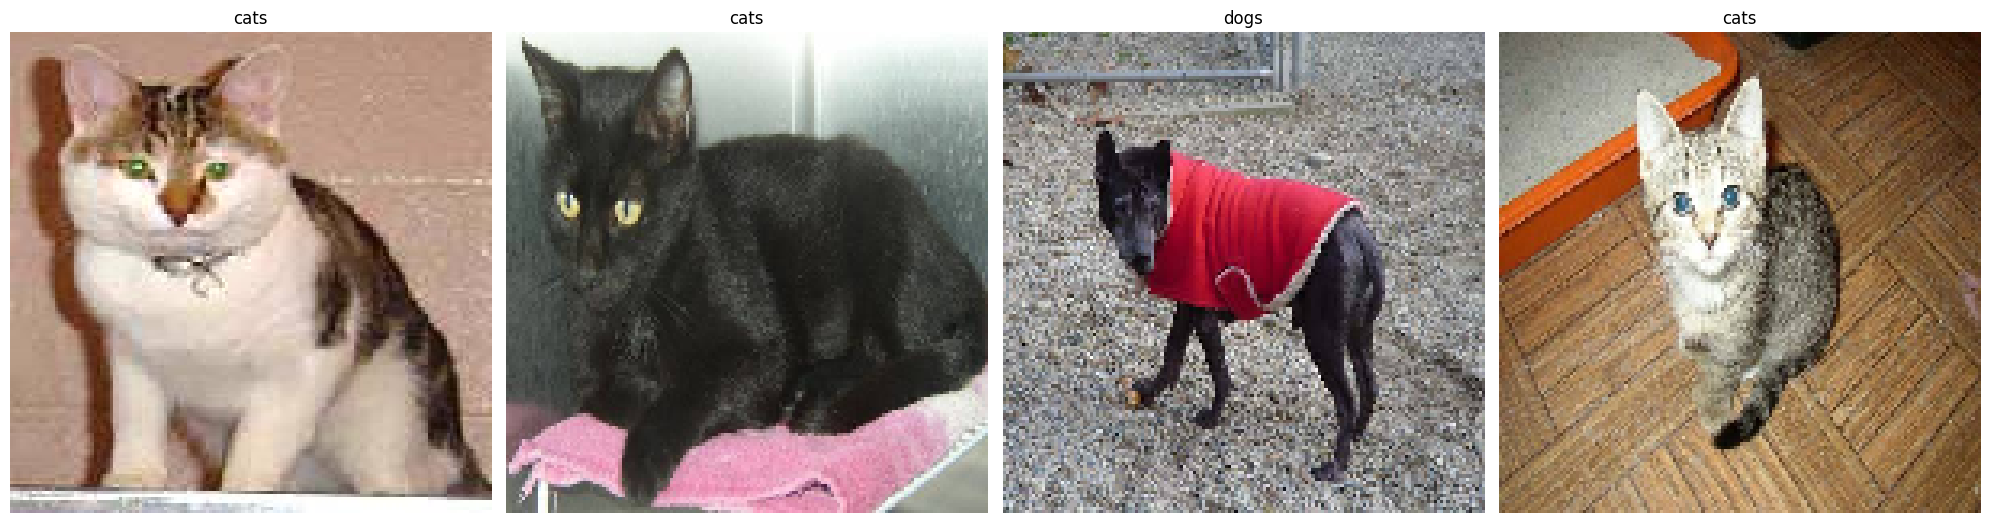

In [20]:
import matplotlib.pyplot as plt

# Function to plot images and their labels
def plot_images_from_generator(generator, num_images=4):
    # Get a batch of images and labels from the generator
    images, labels = next(generator)

    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=(20,20))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        # Image preprocessing might differ, adjust accordingly
        ax.imshow(img)
        # Set the title to the class label
        # Inverse the class indices dictionary to get class names from labels
        class_labels = dict((v,k) for k,v in generator.class_indices.items())
        ax.set_title(class_labels[int(label)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Now, call this function with your training generator
plot_images_from_generator(train_generator, num_images=4)

In [36]:
train_generator.reset()

# Basic CNN Model

In [22]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

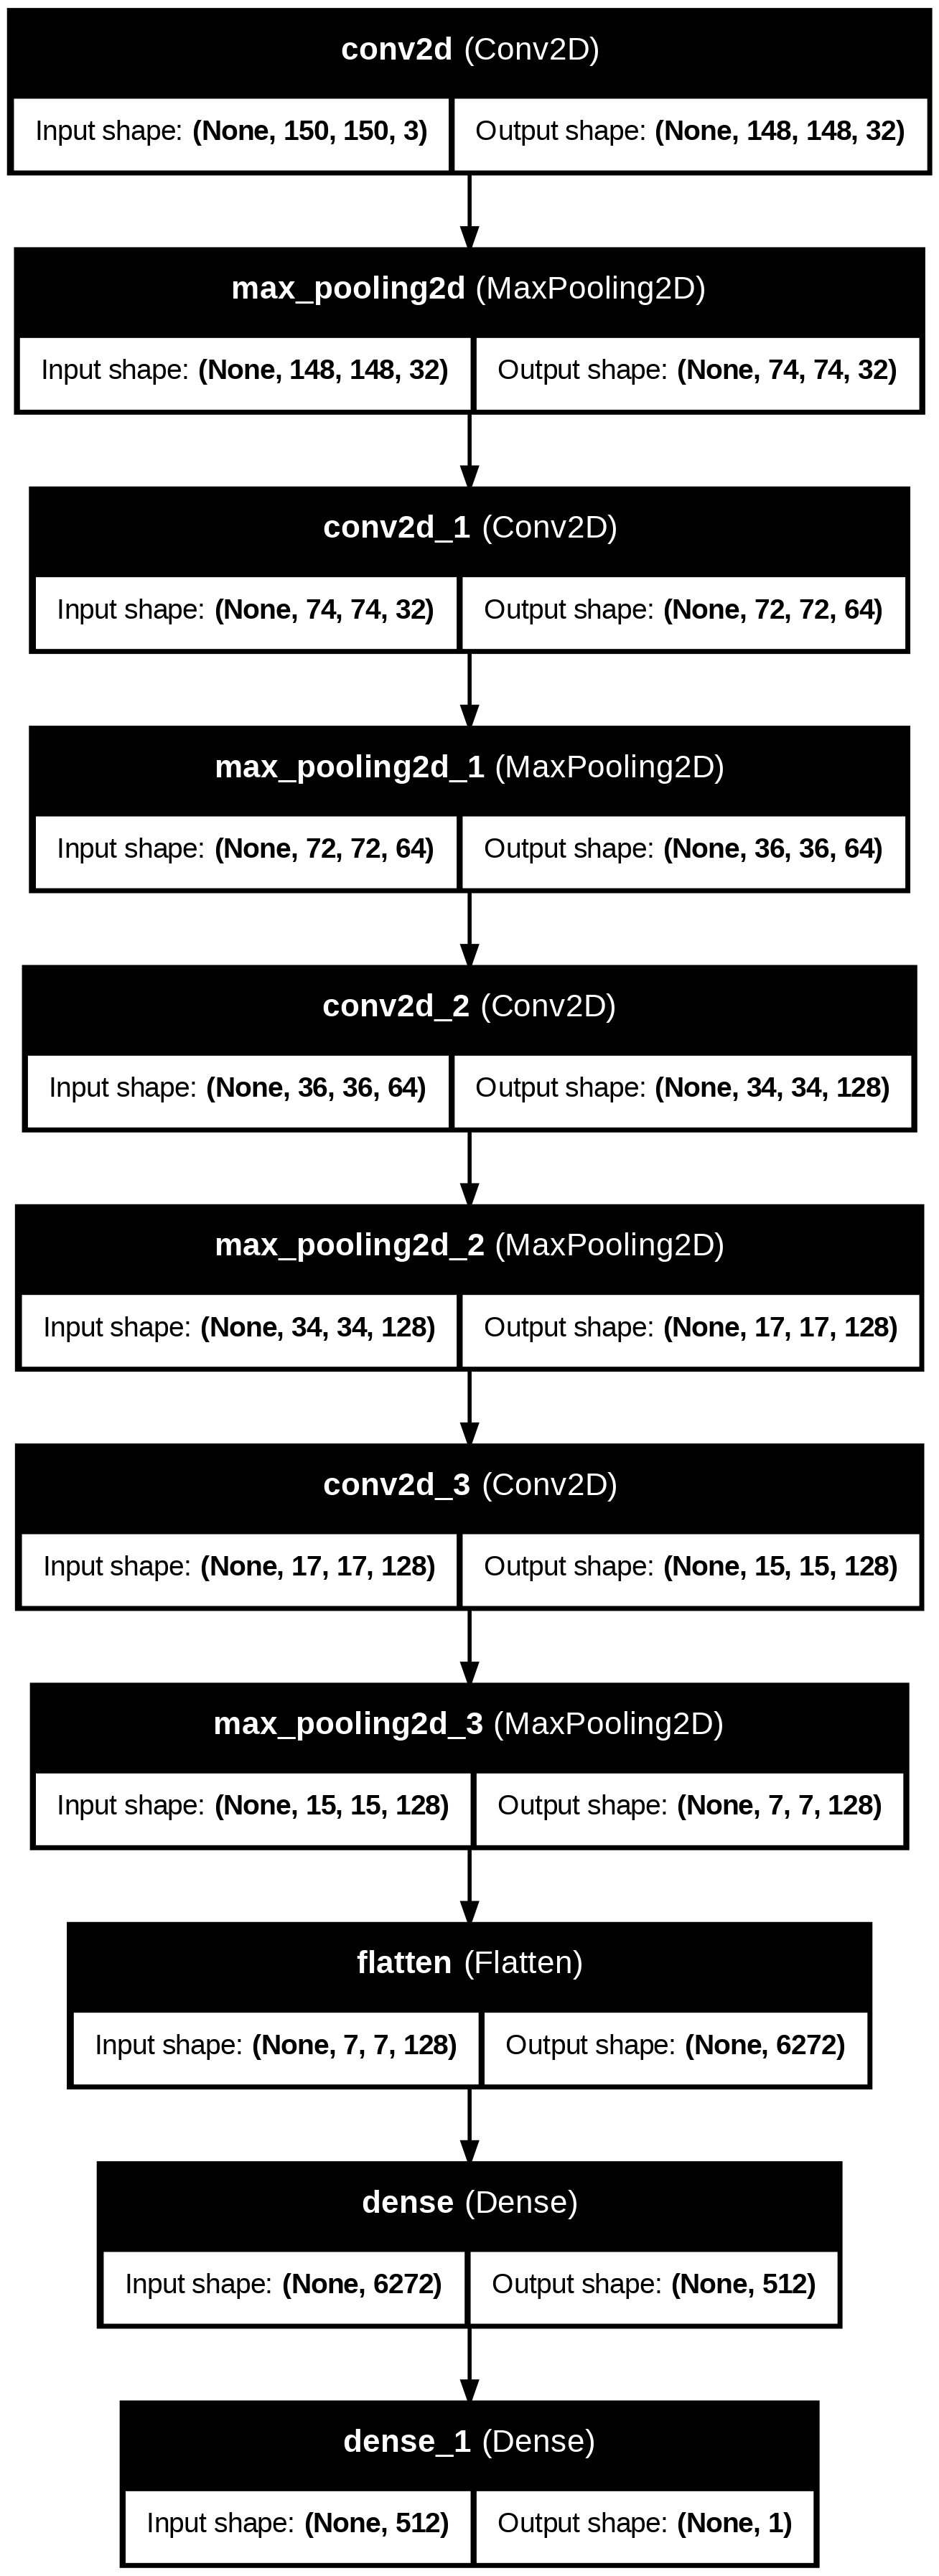

In [ ]:
plot_model(model, to_file = 'Architecture.png',
           show_shapes=True, show_layer_names=True)

## Parameter Calculation in CNN Layers

### Conv2D Layer

The formula to calculate the number of parameters in a Conv2D layer is:

$$\text{Parameters} = (\text{kernel\_height} \times \text{kernel\_width} \times \text{input\_channels} + 1) \times \text{number\_of\_filters}$$

The "+1" accounts for the bias term for each filter.

#### 1. First Conv2D Layer

- Input shape: (150, 150, 3)
- Number of filters: 32
- Filter size: (3, 3)
- Parameters: $$(3 \times 3 \times 3 + 1) \times 32 = 896$$

#### 2. Second Conv2D Layer

- Input channels: 32 (from the previous Conv2D layer)
- Number of filters: 64
- Filter size: (3, 3)
- Parameters: $$(3 \times 3 \times 32 + 1) \times 64 = 18,496$$

#### 3. Third Conv2D Layer

- Input channels: 64
- Number of filters: 128
- Filter size: (3, 3)
- Parameters: $$(3 \times 3 \times 64 + 1) \times 128 = 73,856$$

#### 4. Fourth Conv2D Layer

- Input channels: 128
- Number of filters: 128
- Filter size: (3, 3)
- Parameters: $$(3 \times 3 \times 128 + 1) \times 128 = 147,584$$

### MaxPooling2D Layer

MaxPooling layers do not have parameters; they only reduce the size of the input they're applied to, based on their pool size and stride.

### Flatten Layer

The Flatten layer itself doesn't have parameters. It simply reshapes the input but does not affect the total parameter count.

### Dense Layer

The formula for a Dense (fully connected) layer is:

$$\text{Parameters} = (\text{input\_size} + 1) \times \text{output\_size}$$

#### 1. First Dense Layer

- Assuming Flatten output size: X (you'll need to calculate this based on the output of the last pooling layer).
- Output size: 512
- Parameters: $$(X + 1) \times 512$$

#### 2. Second Dense Layer

- Input size: 512
- Output size: 1 (for binary classification)
- Parameters: $$(512 + 1) \times 1 = 513$$


In [23]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
batch = 20
train_steps = np.ceil(train_generator.samples / batch)
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch)
print(train_steps, validation_steps_per_epoch)

800.0 200.0


In [ ]:
!pip install --upgrade tensorflow keras

In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=800,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=200)

In [ ]:
history.history

In [ ]:
# Adjust lengths to match the shorter array (validation in this case)
min_length = min(len(acc), len(val_acc))

# Trim the training data to match the validation data length
acc = acc[:min_length]
loss = loss[:min_length]

# Use the length of the validation data for the epochs range
epochs_range = range(min_length)

# Now plot the adjusted data
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# Check training generator
# for i in range(5):  # Print the first 5 batches
#     x, y = next(train_generator)
#     print(f"Batch {i+1}: x shape = {x.shape}, y shape = {y.shape}")

# # Check validation generator
# for i in range(5):  # Print the first 5 batches
#     x, y = next(validation_generator)
#     print(f"Batch {i+1}: x shape = {x.shape}, y shape = {y.shape}")

In [ ]:
# print(model.input_shape)

In [ ]:
# Add a print statement to check the validation generator
# for i in range(validation_steps):
#     x, y = next(validation_generator)
#     print(f"Batch {i+1}: x shape = {x.shape}, y shape = {y.shape}")

# history = model.fit(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=10,
#     validation_data=validation_generator,
#     validation_steps=validation_steps)

# Model Evluation


## Initiating Test Generator

## Making test predictions

## Plotting confusion Matrix

# Inference

# Single Image Prediction

# MisClassifcaitons

# Visualising the kernel feature maps.